In [171]:
import os
import nannyml as nml
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [172]:
def data_processing(data , half_chapter):
    df = pd.read_csv(data,  index_col=0)
    df = df.dropna(axis=1, how='all')
    df = df[ df['nchapters'] >= half_chapter ]
    # Delete unrelated columns
    df = df.drop(columns= ['course_id','userid_DI','registered','viewed','explored',
                           'start_time_DI','last_event_DI','incomplete_flag','final_cc_cname_DI'] , axis = 1)
    df = df.dropna( how='any', axis=0)
    df = df[ df['grade']!= " " ]
    df['grade'] = pd.to_numeric(df['grade'])
    if data == "HarvardX_CB22x_2013_Spring.csv" or data == "HarvardX_ER22x_2013_Spring.csv":
      df.loc[:,'nplay_video'] = 0
    #print( y.value_counts() )
    df = pd.get_dummies(df, dtype=float)
    df = df.reset_index(drop=True)
    return df

In [173]:
# OOD data
ionosphere_X = pd.read_csv('ionosphere_X.csv')
ionosphere_y = pd.read_csv('ionosphere_y.csv')
ionosphere = pd.concat([ionosphere_X , ionosphere_y], axis = 1)
ionosphere.columns = [ str(i) for i in range(ionosphere.shape[1]) ]

sonar_X = pd.read_csv('sonar_X.csv')
sonar_y = pd.read_csv('sonar_y.csv')
sonar = pd.concat([sonar_X, sonar_y], axis = 1)
sonar.columns = [ str(i) for i in range(sonar.shape[1]) ]

OOD = pd.concat([sonar, ionosphere])
OOD.shape

(558, 15)

In [174]:
def Normalization(data):
    scaler = MinMaxScaler()
    data = pd.DataFrame( scaler.fit_transform(data) )
    data.columns= [ str(i) for i in range(data.shape[1]) ]
    return data
    
df_train =  data_processing(data = 'MITx_6.00x_2012_Fall.csv', half_chapter = 9)
df_samll_shift = data_processing(data = 'MITx_6.00x_2013_Spring.csv', half_chapter = 9)
df_large_shift = data_processing(data = 'HarvardX_ER22x_2013_Spring.csv', half_chapter = 17 )
df_large_shift_2 = data_processing(data = 'HarvardX_CB22x_2013_Spring.csv', half_chapter = 17 )

df_train = Normalization(df_train)
df_samll_shift = Normalization(df_samll_shift)
df_large_shift = Normalization(df_large_shift)
df_large_shift_2 = Normalization(df_large_shift_2)

reference = df_train

analysis = pd.concat( [df_samll_shift, df_large_shift, OOD], axis = 0)
analysis.shape

(5756, 15)

In [175]:
features_name = [ col for col in reference.columns ]

calc = nml.DataReconstructionDriftCalculator(
    column_names = features_name,
    chunk_size = 1420
)

calc.fit(reference)
results = calc.calculate(analysis)

/Users/eric/miniforge3/envs/my_env/lib/python3.10/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

/Users/eric/miniforge3/envs/my_env/lib/python3.10/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

/Users/eric/miniforge3/envs/my_env/lib/python3.10/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



In [176]:
figure = results.plot(plot_reference=True)
figure.write_image("reconstruction_error_classification.jpg")

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0     [0:1419]           0           0      1419       None     None   
1  [1420:2840]           1        1420      2840       None     None   

             reconstruction_error                                      \
      period       sampling_error     value upper_confidence_boundary   
0  reference             0.031300  1.803962                  1.897862   
1  reference             0.031289  1.786311                  1.880177   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  1.710062        1.821613        1.768659  False  
1                  1.692444        1.821613        1.768659  False

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0     [0:1419]           0           0      1419       None     None   
1  [1420:2839]           1        1420      2839       None     None   
2  [2840:4259]           2        2840      4259       None     None   
3  [4260:5755]           3        4260      5755       None     None   

            reconstruction_error                                      \
     period       sampling_error     value upper_confidence_boundary   
0  analysis             0.031300  2.197192                  2.291091   
1  analysis             0.031300  4.349523                  4.443423   
2  analysis             0.031300  8.507829                  8.601728   
3  analysis             0.030494  8.922728                  9.014212   

                                                                   
  lower_confidence_boundary upper_threshold lower_threshold alert  
0                  2.103292        1.821613        1.768659  True  
1                  4.255623        1.821613        1.768659  True  
2                  8.413929        1.821613        1.768659  True  
3                  8.831245        1.821613        1.768659  True

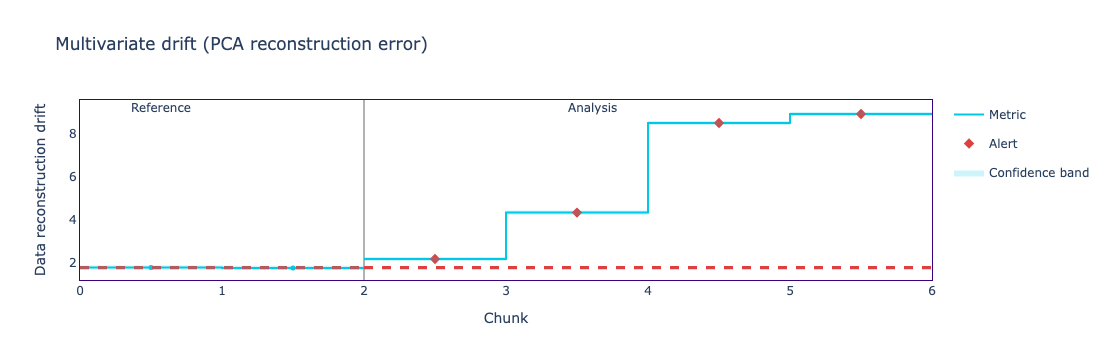

In [177]:
display(results.filter(period='reference').to_df())
display(results.filter(period='analysis').to_df())

figure = results.plot()
figure.show()

In [ ]:
# Regression 

In [200]:
Boston = pd.read_csv('Boston.csv')

naval = pd.read_csv('naval.csv')

OOD = pd.concat([Boston, naval], axis = 0)
OOD.shape

(12440, 12)

In [198]:
train = pd.read_csv('train.csv')
small_shift = pd.read_csv('dev_in.csv')
large_shift = pd.read_csv('dev_out.csv')

train = Normalization(train)
print(train.shape)

small_shift = Normalization(small_shift)
print(small_shift.shape)

large_shift = Normalization(large_shift)
print(large_shift.shape)


(530706, 12)
(18368, 12)
(18368, 12)


In [199]:
reference = train
analysis = pd.concat( [small_shift, large_shift, OOD], axis = 0)
analysis.shape

(49176, 12)

In [201]:
features_name = [ col for col in reference.columns ]

calc = nml.DataReconstructionDriftCalculator(
    column_names = features_name,
    chunk_size = 9000
)

calc.fit(reference)
results = calc.calculate(analysis)

/Users/eric/miniforge3/envs/my_env/lib/python3.10/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



chunk                                                        \
                key chunk_index start_index end_index start_date end_date   
0          [0:8999]           0           0      8999       None     None   
1      [9000:17999]           1        9000     17999       None     None   
2     [18000:26999]           2       18000     26999       None     None   
3     [27000:35999]           3       27000     35999       None     None   
4     [36000:44999]           4       36000     44999       None     None   
5     [45000:53999]           5       45000     53999       None     None   
6     [54000:62999]           6       54000     62999       None     None   
7     [63000:71999]           7       63000     71999       None     None   
8     [72000:80999]           8       72000     80999       None     None   
9     [81000:89999]           9       81000     89999       None     None   
10    [90000:98999]          10       90000     98999       None     None   
11   [99000:107999]          11       99000    107999       None     None   
12  [108000:116999]          12      108000    116999       None     None   
13  [117000:125999]          13      117000    125999       None     None   
14  [126000:134999]          14      126000    134999       None     None   
15  [135000:143999]          15      135000    143999       None     None   
16  [144000:152999]          16      144000    152999       None     None   
17  [153000:161999]          17      153000    161999       None     None   
18  [162000:170999]          18      162000    170999       None     None   
19  [171000:179999]          19      171000    179999       None     None   
20  [180000:188999]          20      180000    188999       None     None   
21  [189000:197999]          21      189000    197999       None     None   
22  [198000:206999]          22      198000    206999       None     None   
23  [207000:215999]          23      207000    215999       None     None   
24  [216000:224999]          24      216000    224999       None     None   
25  [225000:233999]          25      225000    233999       None     None   
26  [234000:242999]          26      234000    242999       None     None   
27  [243000:251999]          27      243000    251999       None     None   
28  [252000:260999]          28      252000    260999       None     None   
29  [261000:269999]          29      261000    269999       None     None   
30  [270000:278999]          30      270000    278999       None     None   
31  [279000:287999]          31      279000    287999       None     None   
32  [288000:296999]          32      288000    296999       None     None   
33  [297000:305999]          33      297000    305999       None     None   
34  [306000:314999]          34      306000    314999       None     None   
35  [315000:323999]          35      315000    323999       None     None   
36  [324000:332999]          36      324000    332999       None     None   
37  [333000:341999]          37      333000    341999       None     None   
38  [342000:350999]          38      342000    350999       None     None   
39  [351000:359999]          39      351000    359999       None     None   
40  [360000:368999]          40      360000    368999       None     None   
41  [369000:377999]          41      369000    377999       None     None   
42  [378000:386999]          42      378000    386999       None     None   
43  [387000:395999]          43      387000    395999       None     None   
44  [396000:404999]          44      396000    404999       None     None   
45  [405000:413999]          45      405000    413999       None     None   
46  [414000:422999]          46      414000    422999       None     None   
47  [423000:431999]          47      423000    431999       None     None   
48  [432000:440999]          48      432000    440999       None     None   
49  [441000:449999]          49      441000    449999       None     None   
50  [45000

chunk                                                        \
             key chunk_index start_index end_index start_date end_date   
0       [0:8999]           0           0      8999       None     None   
1   [9000:17999]           1        9000     17999       None     None   
2  [18000:26999]           2       18000     26999       None     None   
3  [27000:35999]           3       27000     35999       None     None   
4  [36000:49175]           4       36000     49175       None     None   

            reconstruction_error                                      \
     period       sampling_error     value upper_confidence_boundary   
0  analysis             0.010103  1.477801                  1.508111   
1  analysis             0.010103  1.729454                  1.759763   
2  analysis             0.010103  2.215771                  2.246080   
3  analysis             0.010103  2.220055                  2.250364   
4  analysis             0.008350  8.619862                  8.644912   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  1.447492        2.006475        1.156017  False  
1                  1.699145        2.006475        1.156017  False  
2                  2.185462        2.006475        1.156017   True  
3                  2.189746        2.006475        1.156017   True  
4                  8.594813        2.006475        1.156017   True

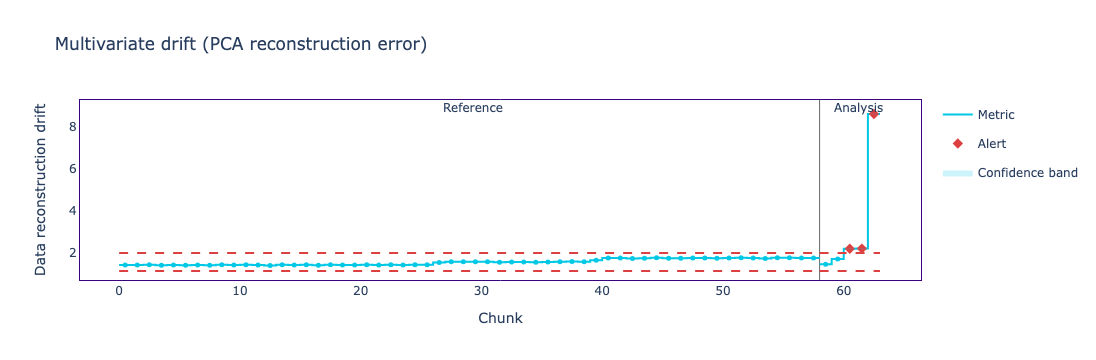

In [202]:
display(results.filter(period='reference').to_df())
display(results.filter(period='analysis').to_df())

figure = results.plot()
figure.show()